## Importing all the Libraries

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import Likelihood, QuantileRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Importing Data

In [2]:
import pandas as pd

data = pd.read_csv("/home/vnk3019/Gaussian_Reduced_Data.csv")
df = data
df = df.dropna()


## Loading Data

In [3]:
from darts.models import TFTModel
from darts.metrics import mape
from darts.timeseries import TimeSeries
import pandas as pd
import numpy as np
from functools import reduce

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

# Assuming 'date' column exists
df = df.sort_values(by=['Tire_ID', 'age_days'])

# Dictionary to store transformed TimeSeries and covariates for each Tire_ID
tire_data_dict = {}

# Get unique Tire_IDs
unique_tire_ids = df['Tire_ID'].unique()

# Define the train and validation Tire_IDs using 70:30 split
split_idx = int(0.7 * len(unique_tire_ids))
train_tire_ids = unique_tire_ids[:split_idx]
val_tire_ids = unique_tire_ids[split_idx:]

# Collect all covariates in a list
all_covariates = []

for tire_id, group in df.groupby('Tire_ID'):
    # Handle indexing and duplicates
    group['age_days'] = group['age_days'].astype(int)
    group.set_index('age_days', inplace=True)
    
    # Ensure a continuous series for 'age_days'
    complete_age_days = pd.RangeIndex(start=group.index.min(), stop=group.index.max()+1)
    group = group[~group.index.duplicated(keep='first')]
    group = group.reindex(complete_age_days).interpolate()
    group = group.reset_index().rename(columns={"index": "age_days"})
    
    # Create TimeSeries from group
    series = TimeSeries.from_dataframe(group, value_cols=['predicted_RCP']).astype(np.float32)

    # Create covariates using all columns except 'predicted_RCP' and 'Tire_ID'
    covariate_cols = group.columns.difference(['predicted_RCP', 'Tire_ID'])
    covariates = TimeSeries.from_dataframe(group, value_cols=covariate_cols).astype(np.float32)

    # Add the processed covariates to the list
    all_covariates.append(covariates)

    # Store series and covariates in the dictionary
    tire_data_dict[tire_id] = {'series': series, 'covariates': covariates}

# Parameters for training
input_chunk_length = 50
output_chunk_length = 50

# Prepare training and validation datasets
training_series = [tire_data_dict[tire_id]['series'] for tire_id in train_tire_ids]
training_covariates = [tire_data_dict[tire_id]['covariates'] for tire_id in train_tire_ids]

validation_series = [tire_data_dict[tire_id]['series'] for tire_id in val_tire_ids]
validation_covariates = [tire_data_dict[tire_id]['covariates'] for tire_id in val_tire_ids]

## Loading the saved TFT Model

In [5]:
input_chunk_length = 50
output_chunk_length = 50  # Forecast horizon of 50 time steps

from pytorch_lightning.callbacks import Callback
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]

class LossLogger(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []

    # will automatically be called at the end of each epoch
    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.train_loss.append(float(trainer.callback_metrics["train_loss"]))

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule") -> None:
        self.val_loss.append(float(trainer.callback_metrics["val_loss"]))


loss_logger = LossLogger()

tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=output_chunk_length,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=50,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={"callbacks": [loss_logger]},
)


tft_model = tft_model.load("/home/vnk3019/RCP_TFT_11202023_nn.pt")


## Class for TFT Predictions

In [6]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from darts.timeseries import TimeSeries
import matplotlib.pyplot as plt
from scipy.stats import norm

class TirePredictor():

    def __init__(self, tft_model, df, tire_data_dict):
        self.tft_model = tft_model
        self.df = df
        self.tire_data_dict = tire_data_dict

    def predict_with_sliding_windows_and_gp(self, test_tire_id, input_chunk_length, output_chunk_length=None):
        actual_series = self.tire_data_dict[test_tire_id]['series']
        forecast = self._predict_with_sliding_windows_and_gp_helper(actual_series, self.tire_data_dict[test_tire_id]['covariates'], input_chunk_length, output_chunk_length)

        # Extract casing mileage values and interpolate
        casing_mileage = self.df[self.df["Tire_ID"] == test_tire_id]["casing_mileage_kms"].values
        real_casing_mileage = casing_mileage

        interpolated_casing_mileage = np.linspace(0, max(real_casing_mileage), len(forecast.values()))

        return forecast, interpolated_casing_mileage, actual_series

    def _predict_with_sliding_windows_and_gp_helper(self, series, covariates, input_chunk_length, output_chunk_length=None):
        total_predictions = np.zeros(len(series))
        prediction_counts = np.zeros(len(series))

        # Initialize the first `input_chunk_length` entries
        total_predictions[:input_chunk_length] = series.values()[:input_chunk_length].flatten()
        prediction_counts[:input_chunk_length] = 1

        if output_chunk_length == None:
            output_chunk_length = len(total_predictions) - 50


        all_forecasts = []
        all_forecasts_std = []
        all_actuals = []

        for start in range(0, len(series) - input_chunk_length - output_chunk_length + 1, output_chunk_length):
            end = start + input_chunk_length
            future_end = end + output_chunk_length

            if start ==0:
                input_series_chunk = series[start:end]
                input_covariate_chunk = covariates[start:future_end]
            else:
                input_series_chunk = series[start-50:end-50]
                input_covariate_chunk = covariates[start-50:future_end-50]


            #print(input_series_chunk)

            # Prediction with TFT model
            forecast = self.tft_model.predict(n=output_chunk_length, series=input_series_chunk, future_covariates=input_covariate_chunk, num_samples=150, verbose = False)
            #print(input_series_chunk.time_index)
            #print(input_covariate_chunk.time_index)

            all_forecasts.extend(forecast.values())

            # Here we directly use the model's std for each forecast
            all_forecasts_std.extend(forecast.std().values())
            all_actuals.extend(series[end:future_end].values())

            for i, value in enumerate(forecast.values().tolist()):
                total_predictions[end + i] += value
                prediction_counts[end + i] += 1

            # Use the forecast to update the series for the next window
            forecast_values = forecast.values()
            series = TimeSeries.from_times_and_values(series.time_index, np.concatenate([series.values()[:end], forecast_values, series.values()[end + output_chunk_length:]]))


        return forecast







## Single Tire_ID Predictions

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
input_chunk_length = 50
test_tire_id = 'STX01'
tire_predictor = TirePredictor(tft_model, df, tire_data_dict)
forecast_1, interpolated_casing_mileage_1, _ = tire_predictor.predict_with_sliding_windows_and_gp(test_tire_id, input_chunk_length, output_chunk_length=None)

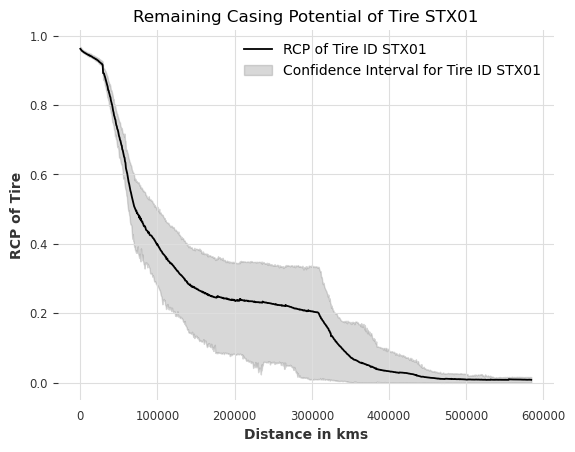

In [8]:
import matplotlib.pyplot as plt

def plot_tire_forecast(interpolated_casing_mileage, forecast, test_tire_id, confidence_interval=0.8):
    lower_bound = (1 - confidence_interval) / 2
    upper_bound = 1 - lower_bound

    plt.plot(interpolated_casing_mileage, forecast.mean().values(), label=f"RCP of Tire ID {test_tire_id}")
    plt.fill_between(interpolated_casing_mileage, 
                     forecast.quantile(quantile=lower_bound).values().flatten(), 
                     forecast.quantile(quantile=upper_bound).values().flatten(), 
                     alpha=0.3, color='grey', 
                     label=f'Confidence Interval for Tire ID {test_tire_id}')
    plt.title(f"Remaining Casing Potential of Tire {test_tire_id}")
    plt.xlabel("Distance in kms")
    plt.ylabel("RCP of Tire")
    plt.legend()
    plt.show()

plot_tire_forecast(interpolated_casing_mileage_1, forecast_1, test_tire_id)